# Online Contextual Bandits
Analyzing the Bibtex dataset using algorithms proposed in Cortes, 2018 (https://arxiv.org/abs/1811.04383)

This notebook is adapted from https://github.com/david-cortes/contextualbandits/blob/master/example/online_contextual_bandits.ipynb

In [1]:
%load_ext autotime
from tqdm.auto import tqdm
import os

import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.datasets import load_svmlight_file

import plotly.express as px
import plotly.io as pio
import plotly.graph_objs as go
pd.options.plotting.backend = "plotly"
pio.renderers.default = "jpeg"

time: 2.01 s (started: 2021-05-11 17:52:56 -04:00)


In [2]:
dataset = 'Bibtex'
res_path = os.path.join('..', 'data', 'results')

time: 0 ns (started: 2021-05-11 17:52:58 -04:00)


### Reading the data

Loading the data - format is a sparse text file as used in libsvm and others, but with the first line indicating the number of rows, columns, and classes:

In [3]:

def parse_data(filename):
    with open(filename, "rb") as f:
        infoline = f.readline()
        infoline = re.sub(r"^b'", "", str(infoline))
        n_features = int(re.sub(r"^\d+\s(\d+)\s\d+.*$", r"\1", infoline))
        features, labels = load_svmlight_file(f, n_features=n_features, multilabel=True)
    mlb = MultiLabelBinarizer()
    labels = mlb.fit_transform(labels)
    features = np.array(features.todense())
    features = np.ascontiguousarray(features)
    return features, labels

X, y = parse_data(f"../data/{dataset}_data.txt")
n_feats = X.shape[1]
n_actions = y.shape[1]
n_obs = y.shape[0]
print(f'Observations: {n_obs}')
print(f'Features: {n_feats}')
print(f'Categories: {n_actions}')

Observations: 7395
Features: 1836
Categories: 159
time: 453 ms (started: 2021-05-11 17:53:06 -04:00)


In [4]:
random_seed = 23

time: 0 ns (started: 2021-05-11 17:53:08 -04:00)


## Full-batch models

### Replication*

In [5]:
from sklearn.linear_model import LogisticRegression
from contextualbandits.online import BootstrappedUCB, BootstrappedTS, LogisticUCB, \
            SeparateClassifiers, EpsilonGreedy, AdaptiveGreedy, ExploreFirst, \
            ActiveExplorer, SoftmaxExplorer
from copy import deepcopy

nchoices = y.shape[1]
base_algorithm = LogisticRegression(solver='lbfgs', warm_start=True)
beta_prior = ((3./nchoices, 4), 2) # until there are at least 2 observations of each class, will use this prior
beta_prior_ucb = ((5./nchoices, 4), 2) # UCB gives higher numbers, thus the higher positive prior
beta_prior_ts = ((2./np.log2(nchoices), 4), 2)
### Important!!! the default values for beta_prior will be changed in version 0.3


time: 235 ms (started: 2021-05-11 17:53:11 -04:00)


In [6]:
## The base algorithm is embedded in different metaheuristics
model_dict = {'ucb':BootstrappedUCB(deepcopy(base_algorithm), nchoices = nchoices,
                                    beta_prior = beta_prior_ucb, percentile = 80,
                                    random_state = random_seed),
              'ts':BootstrappedTS(deepcopy(base_algorithm), nchoices = nchoices,
                                 beta_prior = beta_prior_ts, random_state = random_seed),
              'ovr':SeparateClassifiers(deepcopy(base_algorithm), nchoices = nchoices,
                                  beta_prior = beta_prior, random_state = random_seed),
              'egr':EpsilonGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                               beta_prior = beta_prior, random_state = random_seed),
              'lucb':LogisticUCB(nchoices = nchoices, percentile = 70,
                           beta_prior = beta_prior_ts, random_state = random_seed),
              'agr':AdaptiveGreedy(deepcopy(base_algorithm), nchoices=nchoices,
                                     decay_type='threshold',
                                     beta_prior = beta_prior, random_state = random_seed),
              'agr2':AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                                      decay_type='percentile', decay=0.9997,
                                       beta_prior=beta_prior, random_state = random_seed),
              'efr':ExploreFirst(deepcopy(base_algorithm), nchoices = nchoices,
                             explore_rounds=1500, beta_prior=None, random_state = random_seed),
              'ac':ActiveExplorer(deepcopy(base_algorithm), nchoices = nchoices,
                                 beta_prior=beta_prior, random_state = random_seed),
              'aac':AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                                        active_choice='weighted', decay_type='percentile', decay=0.9997,
                                        beta_prior=beta_prior, random_state = random_seed),
              'sft':SoftmaxExplorer(deepcopy(base_algorithm), nchoices = nchoices,
                                   beta_prior=beta_prior, random_state = random_seed)}


time: 16 ms (started: 2021-05-11 17:53:12 -04:00)


In [10]:
reward_dict = {z:list() for z in model_dict.keys()}

ttime_dict = deepcopy(reward_dict)


time: 0 ns (started: 2021-05-05 11:14:09 -04:00)


Now running the experiment:

In [7]:
# rounds are simulated from the full dataset
def simulate_rounds(model, rewards, actions_hist, ttime, X_global, y_global, batch_st, batch_end, fit=True):
    start = pd.Timestamp.now()
    
    np.random.seed(batch_st)
    
    ## choosing actions for this batch
    actions_this_batch = model.predict(X_global[batch_st:batch_end, :]).astype('uint8')
    
    # keeping track of the sum of rewards received
    rewards.append(y_global[np.arange(batch_st, batch_end), actions_this_batch].sum())
    
    # adding this batch to the history of selected actions
    new_actions_hist = np.append(actions_hist, actions_this_batch)
    
    # now refitting the algorithms after observing these new rewards
    np.random.seed(random_seed)
    if fit:
        model.fit(X_global[:batch_end, :], new_actions_hist, y_global[np.arange(batch_end), new_actions_hist],
                  warm_start = True)
    
    ttime.append((pd.Timestamp.now() - start)/pd.Timedelta('1m'))
    
    return new_actions_hist



time: 0 ns (started: 2021-05-11 17:53:15 -04:00)


In [65]:
# batch size - algorithms will be refit after N rounds
batch_size = 50
np.random.seed(random_seed)

# initial seed - all policies start with the same small random selection of actions/rewards
first_batch = X[:batch_size, :]
action_chosen = np.random.randint(nchoices, size=batch_size)
rewards_received = y[np.arange(batch_size), action_chosen]

# fitting models for the first time
for k, model in model_dict.items():
    model.fit(X=first_batch, a=action_chosen, r=rewards_received)
    
# these lists will keep track of which actions does each policy choose
action_dict = {z:action_chosen.copy() for z in model_dict.keys()}


time: 2.33 s (started: 2021-05-03 22:11:45 -04:00)


In [66]:
# now running all the simulation
for i in tqdm(range(int(np.floor(X.shape[0] / batch_size))), leave=False):
    batch_st = (i + 1) * batch_size
    batch_end = (i + 2) * batch_size
    batch_end = np.min([batch_end, X.shape[0]])
    
    for k in model_dict:
        action_dict[k] = simulate_rounds(model_dict[k],
                                             reward_dict[k],
                                             action_dict[k],
                                             ttime_dict[k],
                                             X, y,
                                             batch_st, batch_end,
                                             fit=batch_end!=len(X)) # don't refit on last run
        

  0%|          | 0/147 [00:00<?, ?it/s]

time: 28min 20s (started: 2021-05-03 22:11:49 -04:00)


In [100]:
# write out results
subfold = 'baseline'
df_action = pd.DataFrame(action_dict)
df_action.to_csv(os.path.join(res_path, subfold, 
                              f'{dataset}_{model_name}_actions.csv'))

df_reward = pd.DataFrame(reward_dict, index=ns)
df_reward.to_csv(os.path.join(res_path, subfold,
                              f'{dataset}_{model_name}_rewards.csv'))

df_ttime = pd.DataFrame(ttime_dict, index=ns)
df_ttime.to_csv(os.path.join(res_path, subfold,
                             f'{dataset}_{model_name}_train_time.csv'))

time: 62 ms (started: 2021-05-03 23:16:28 -04:00)


#### Visualizing results:

In [36]:
legend_dict = {'ucb':"Bootstrapped Upper Confidence Bound (C.I.=80%)",
               'ts':"Bootstrapped Thompson Sampling",
               'egr':"Epsilon-Greedy (p0=20%, decay=0.9999)",
               'lucb':"Logistic Upper Confidence Bound (C.I.=70%)",
               'agr':"Adaptive Greedy (decaying threshold)",
               'agr2':"Adaptive Greedy (p0=30%, decaying percentile)",
               'efr':"Explore First (n=1,500)",
               'ac':"Active Explorer",
               'aac':"Adaptive Active Greedy",
               'sft':"Softmax Explorer",
               'best':"Overall Best Arm (no context)"}
               

time: 0 ns (started: 2021-05-03 21:52:41 -04:00)


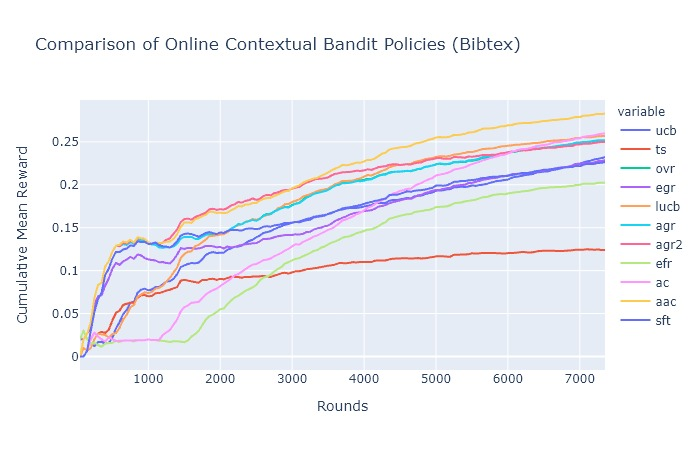

time: 766 ms (started: 2021-05-04 22:45:37 -04:00)


In [106]:
df_reward = pd.read_csv(os.path.join(res_path, 'baseline', f'{dataset}_rewards.csv'), index_col=0)
fig = px.line(df_reward.cumsum().divide(df_reward.index.values.reshape(-1,1)),
              title=f'''Comparison of Online Contextual Bandit Policies ({dataset})''')
fig.update_yaxes(title='Cumulative Mean Reward')
fig.update_xaxes(title='Rounds')
fig.show()

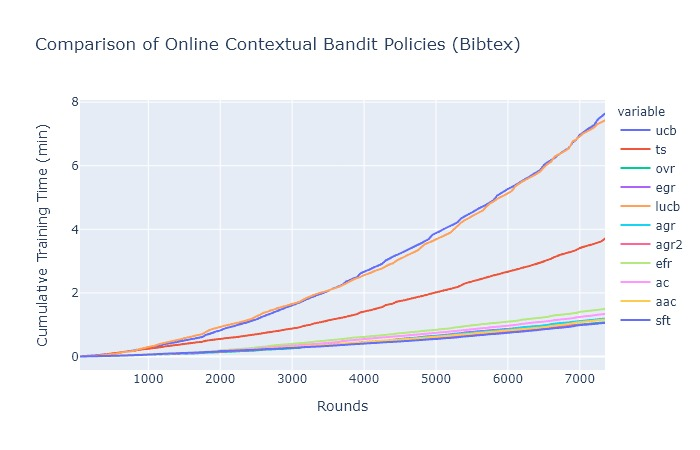

time: 718 ms (started: 2021-05-04 22:45:52 -04:00)


In [108]:
df_ttime = pd.read_csv(os.path.join(res_path, 'baseline',
                                    f'{dataset}_train_time.csv'), index_col=0)
fig = px.line(df_ttime.cumsum(),
              title=f'''Comparison of Online Contextual Bandit Policies ({dataset})''')
fig.update_yaxes(title='Cumulative Training Time (min)')
fig.update_xaxes(title='Rounds')
fig.show()

### Reducing Train Time
In this section, we look at ways to dynamically adjust the batch frequency to reduce train time

In [40]:
epsilon_greedy = EpsilonGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                               beta_prior = beta_prior, random_state = random_seed)

model_name = ['egr']
model_dict = {'egr':epsilon_greedy}
reward_dict = {z:list() for z in model_name}

ttime_dict = deepcopy(reward_dict)

# batch size - algorithms will be refit after N rounds
batch_size = 50
np.random.seed(random_seed)


# initial seed - all policies start with the same small random selection of actions/rewards
first_batch = X[:batch_size, :]

action_chosen = np.random.randint(nchoices, size=batch_size)
rewards_received = y[np.arange(batch_size), action_chosen]

# fitting models for the first time
for k, model in model_dict.items():
    model.fit(X=first_batch, a=action_chosen, r=rewards_received)
    
# these lists will keep track of which actions does each policy choose
action_dict = {z:action_chosen.copy() for z in model_name}
ns = list()
# now running all the simulation
for i in tqdm(range(int(np.floor(X.shape[0] / batch_size))), leave=False):
    batch_st = (i + 1) * batch_size
    batch_end = (i + 2) * batch_size
    batch_end = np.min([batch_end, X.shape[0]])
    ns.append(batch_end)
    
    for k in model_dict:
        action_dict[k] = simulate_rounds(model_dict[k],
                                             reward_dict[k],
                                             action_dict[k],
                                             ttime_dict[k],
                                             X, y,
                                             batch_st, batch_end,
                                             fit=batch_end!=len(X)) # don't refit on last run

  0%|          | 0/147 [00:00<?, ?it/s]

time: 47.3 s (started: 2021-05-04 21:40:44 -04:00)


In [48]:
train_time=dict()
train_reward=dict()
train_ns=dict()

time: 0 ns (started: 2021-05-04 21:48:43 -04:00)


In [49]:
label = 'batch_50'
train_reward[label] = reward_dict['egr']
train_time[label] = ttime_dict['egr']
train_ns[label] = ns

time: 16 ms (started: 2021-05-04 21:48:44 -04:00)


In [84]:
for pct in np.arange(0.01,.101, 0.01):   
    epsilon_greedy = EpsilonGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                                   beta_prior = beta_prior, random_state = random_seed)

    model_name = ['egr']
    model_dict = {'egr':epsilon_greedy}
    reward_dict = {z:list() for z in model_name}

    ttime_dict = deepcopy(reward_dict)

    # minimum batch size
    min_batch = 50
    incr_batch_pct = pct

    # create batch index
    n = 0
    incrs = list()
    ns = [0]

    while n<len(X):
        incr = max(50, int(incr_batch_pct*n))
        if n+incr>len(X):
            incr = len(X)-n
        incrs.append(incr)
        n+=incr
        ns.append(n)

    print(f'The models will be refit {len(ns)-1} times')

    # initial seed - all policies start with the same small random selection of actions/rewards
    first_batch = X[:min_batch, :]

    action_chosen = np.random.randint(nchoices, size=min_batch)
    rewards_received = y[np.arange(min_batch), action_chosen]

    # fitting models for the first time
    for k, model in model_dict.items():
        model.fit(X=first_batch, a=action_chosen, r=rewards_received)

    # these lists will keep track of which actions does each policy choose
    action_dict = {z:action_chosen.copy() for z in model_name}

    # now running all the simulation
    for i in tqdm(range(2, len(ns)), leave=False):
        batch_st = ns[i-1]
        batch_end = ns[i]

        for k in model_dict:
            action_dict[k] = simulate_rounds(model_dict[k],
                                                 reward_dict[k],
                                                 action_dict[k],
                                                 ttime_dict[k],
                                                 X, y,
                                                 batch_st, batch_end)

    label = incr_batch_pct
    train_reward[label] = reward_dict['egr']
    train_time[label] = ttime_dict['egr']
    train_ns[label] = ns[2:]


The models will be refit 140 times


  0%|          | 0/139 [00:00<?, ?it/s]

The models will be refit 106 times


  0%|          | 0/105 [00:00<?, ?it/s]

The models will be refit 84 times


  0%|          | 0/83 [00:00<?, ?it/s]

The models will be refit 71 times


  0%|          | 0/70 [00:00<?, ?it/s]

The models will be refit 62 times


  0%|          | 0/61 [00:00<?, ?it/s]

The models will be refit 55 times


  0%|          | 0/54 [00:00<?, ?it/s]

The models will be refit 49 times


  0%|          | 0/48 [00:00<?, ?it/s]

The models will be refit 45 times


  0%|          | 0/44 [00:00<?, ?it/s]

The models will be refit 42 times


  0%|          | 0/41 [00:00<?, ?it/s]

The models will be refit 39 times


  0%|          | 0/38 [00:00<?, ?it/s]

time: 3min 29s (started: 2021-05-04 22:17:47 -04:00)


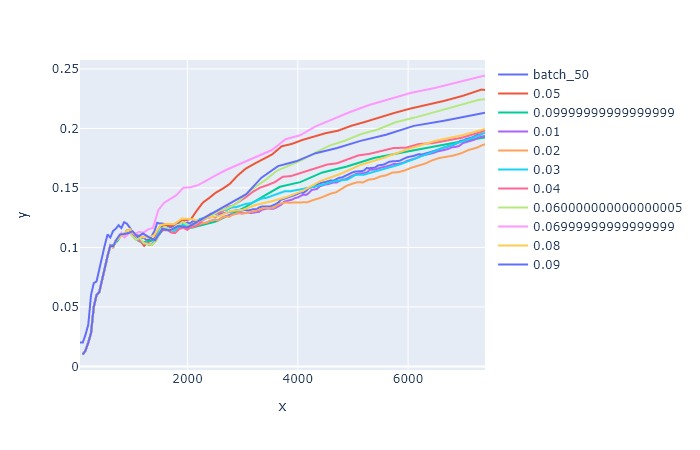

time: 203 ms (started: 2021-05-04 22:21:19 -04:00)


In [85]:
for i, k in enumerate(train_ns):
    if i==0:
        fig = px.line(x=train_ns[k], 
                      y=np.cumsum(train_reward[k])/train_ns[k])
        fig.update_traces(name=k, showlegend=True)
    else:
        fig.add_trace(go.Scatter(x=train_ns[k], 
                                 y=np.cumsum(train_reward[k])/train_ns[k], name=str(k)))
fig.show()

In [86]:
x=list()
for k in train_time:
    x.append(np.cumsum(train_time[k])[-1])
    

time: 0 ns (started: 2021-05-04 22:24:10 -04:00)


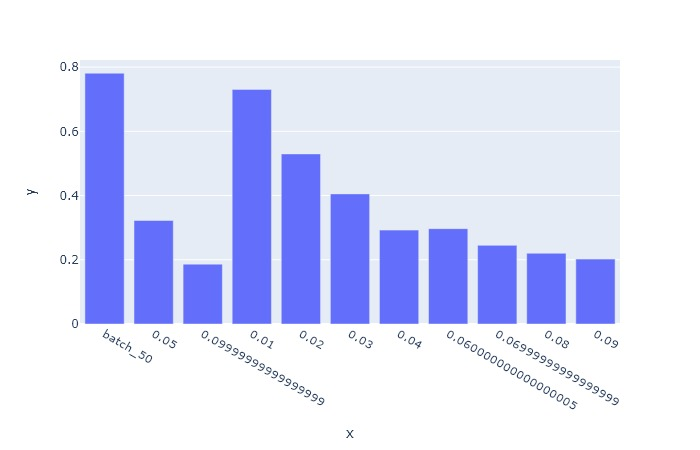

time: 156 ms (started: 2021-05-04 22:26:08 -04:00)


In [92]:
px.bar(y=x, x=[str(z) for z in train_time.keys()])

### Additional Hyper Parameter Configurations

In [11]:
from utils import run_simulation

time: 31 ms (started: 2021-05-11 17:55:12 -04:00)


In [18]:
min_batch_size=50
incr_batch_pct=0.075

time: 0 ns (started: 2021-05-11 17:56:41 -04:00)


#### Epsilon-Greedy Hyperparameter Tuning

In [19]:
model_name = 'egr'

# build hyperparameter grid (seperate models)
model_dict={}
for i in np.arange(0.10, 0.91, 0.1):
    label = str(int(np.round(i*100, 0)))
    model_dict[f'{model_name}_{label}'] = EpsilonGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                                              beta_prior = beta_prior, random_state = random_seed,
                                              explore_prob=i)
    
reward_dict = {z:list() for z in model_dict.keys()}
ttime_dict = deepcopy(reward_dict)

time: 31 ms (started: 2021-05-11 17:56:47 -04:00)


In [20]:
# run simulation
model_dict, reward_dict, action_dict, ttime_dict, ns = run_simulation(X, y, model_dict, reward_dict, ttime_dict, 
                                                         min_batch=min_batch_size, incr_batch_pct=incr_batch_pct)
# write out results
subfold = 'tuning'
df_action = pd.DataFrame(action_dict)
df_action.to_csv(os.path.join(res_path, subfold, 
                              f'{dataset}_{model_name}_actions.csv'))

df_reward = pd.DataFrame(reward_dict, index=ns)
df_reward.to_csv(os.path.join(res_path, subfold,
                              f'{dataset}_{model_name}_rewards.csv'))

df_ttime = pd.DataFrame(ttime_dict, index=ns)
df_ttime.to_csv(os.path.join(res_path, subfold,
                             f'{dataset}_{model_name}_train_time.csv'))

The models will be refit 46 times


  0%|          | 0/46 [00:00<?, ?it/s]

time: 1min 58s (started: 2021-05-11 17:56:48 -04:00)


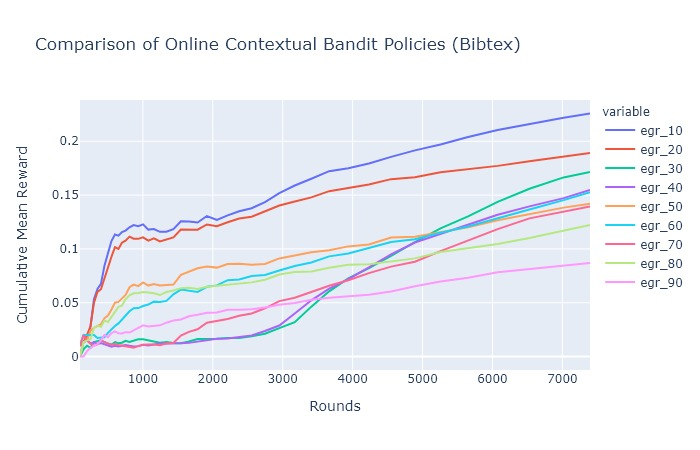

time: 313 ms (started: 2021-05-11 17:58:46 -04:00)


In [21]:
df_reward = pd.read_csv(os.path.join(res_path, 'tuning',
                                     f'{dataset}_{model_name}_rewards.csv'), index_col=0)
fig = px.line(df_reward.cumsum().divide(df_reward.index.values.reshape(-1,1)),
              title=f'''Comparison of Online Contextual Bandit Policies ({dataset})''')
fig.update_yaxes(title='Cumulative Mean Reward')
fig.update_xaxes(title='Rounds')
fig.show()

#### SoftmaxExplorer

In [22]:
model_name = 'sft'

# build hyperparameter grid (seperate models)
model_dict={}
for i in np.arange(1.0000, 1.00101, 0.0001):
    label = str(int(np.round((i-1)*10000, 0)))
    model_dict[f'{model_name}_i{label}'] = SoftmaxExplorer(deepcopy(base_algorithm), nchoices = nchoices,
                                                  beta_prior=beta_prior, 
                                                  random_state = random_seed,
                                                  inflation_rate=i)
    
reward_dict = {z:list() for z in model_dict.keys()}
ttime_dict = deepcopy(reward_dict)


time: 15 ms (started: 2021-05-11 17:59:45 -04:00)


In [23]:
# run simulation
model_dict, reward_dict, action_dict, ttime_dict, ns = run_simulation(X, y, model_dict, reward_dict, ttime_dict, 
                                                                      min_batch=min_batch_size, incr_batch_pct=incr_batch_pct)

# write out results
subfold = 'tuning'
df_action = pd.DataFrame(action_dict)
df_action.to_csv(os.path.join(res_path, subfold, 
                              f'{dataset}_{model_name}_actions.csv'))

df_reward = pd.DataFrame(reward_dict, index=ns)
df_reward.to_csv(os.path.join(res_path, subfold,
                              f'{dataset}_{model_name}_rewards.csv'))

df_ttime = pd.DataFrame(ttime_dict, index=ns)
df_ttime.to_csv(os.path.join(res_path, subfold,
                             f'{dataset}_{model_name}_train_time.csv'))


The models will be refit 46 times


  0%|          | 0/46 [00:00<?, ?it/s]

time: 2min 29s (started: 2021-05-11 17:59:45 -04:00)


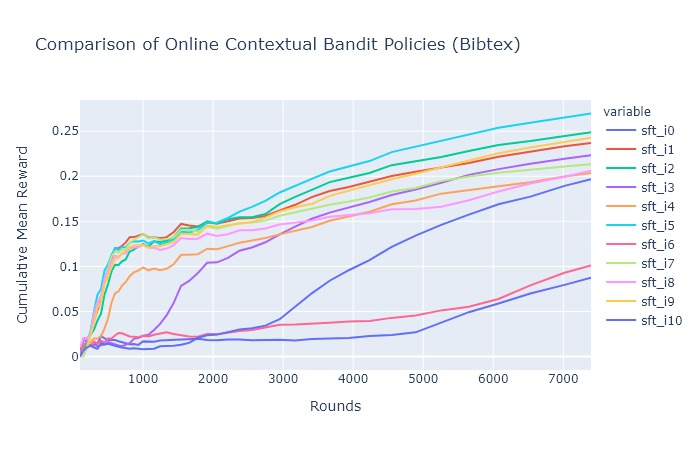

time: 343 ms (started: 2021-05-11 18:02:15 -04:00)


In [24]:
df_reward = pd.read_csv(os.path.join(res_path, 'tuning',
                                     f'{dataset}_{model_name}_rewards.csv'), index_col=0)
fig = px.line(df_reward.cumsum().divide(df_reward.index.values.reshape(-1,1)),
              title=f'''Comparison of Online Contextual Bandit Policies ({dataset})''')
fig.update_yaxes(title='Cumulative Mean Reward')
fig.update_xaxes(title='Rounds')
fig.show()


#### ContextualAdaptiveGreedy

In [25]:
model_name = 'agr'

# build hyperparameter grid (seperate models)
model_dict={}
for i in np.arange(1, 10.1, 1):
    label = str(int(np.round(i)))
    model_dict[f'{model_name}_thr{label}'] = AdaptiveGreedy(deepcopy(base_algorithm), nchoices=nchoices,
                                     decay_type='threshold', initial_thr=i/y.shape[1],
                                     beta_prior=beta_prior, random_state=random_seed)
    
reward_dict = {z:list() for z in model_dict.keys()}
ttime_dict = deepcopy(reward_dict)

time: 16 ms (started: 2021-05-11 18:02:15 -04:00)


In [26]:
# run simulation
model_dict, reward_dict, action_dict, ttime_dict, ns = \
run_simulation(X, y, model_dict, reward_dict, ttime_dict, 
               min_batch=min_batch_size, incr_batch_pct=incr_batch_pct)

# write out results
subfold = 'tuning'
df_action = pd.DataFrame(action_dict)
df_action.to_csv(os.path.join(res_path, subfold, 
                              f'{dataset}_{model_name}_actions.csv'))

df_reward = pd.DataFrame(reward_dict, index=ns)
df_reward.to_csv(os.path.join(res_path, subfold,
                              f'{dataset}_{model_name}_rewards.csv'))

df_ttime = pd.DataFrame(ttime_dict, index=ns)
df_ttime.to_csv(os.path.join(res_path, subfold,
                             f'{dataset}_{model_name}_train_time.csv'))


The models will be refit 46 times


  0%|          | 0/46 [00:00<?, ?it/s]

time: 2min 38s (started: 2021-05-11 18:02:15 -04:00)


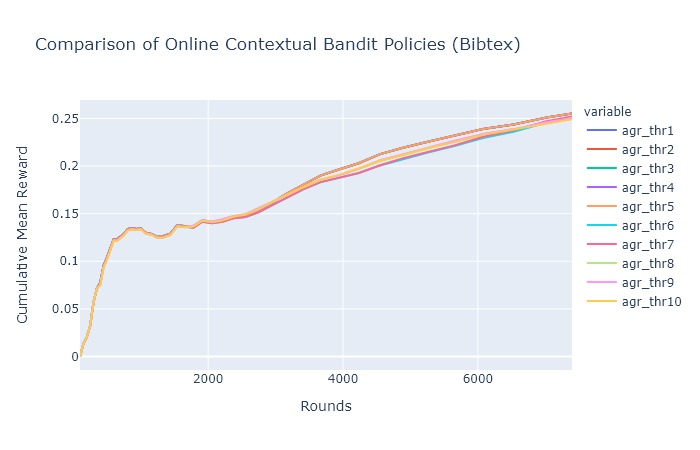

time: 312 ms (started: 2021-05-11 18:04:53 -04:00)


In [27]:
df_reward = pd.read_csv(os.path.join(res_path, 'tuning',
                                     f'{dataset}_{model_name}_rewards.csv'), index_col=0)
fig = px.line(df_reward.cumsum().divide(df_reward.index.values.reshape(-1,1)),
              title=f'''Comparison of Online Contextual Bandit Policies ({dataset})''')
fig.update_yaxes(title='Cumulative Mean Reward')
fig.update_xaxes(title='Rounds')
fig.show()


#### ContextualAdaptiveGreedy2

In [28]:
model_name = 'agr2'

# build hyperparameter grid (seperate models)
model_dict={}
for i in np.arange(5, 51, 5):
    label = str(int(np.round(i)))
    model_dict[f'{model_name}_pct{label}'] = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                                      decay_type='percentile', decay=0.9997, 
                                      percentile=int(np.round(i)),
                                      beta_prior=beta_prior, random_state = random_seed)
    
reward_dict = {z:list() for z in model_dict.keys()}
ttime_dict = deepcopy(reward_dict)

time: 32 ms (started: 2021-05-11 18:04:54 -04:00)


In [29]:
# run simulation
model_dict, reward_dict, action_dict, ttime_dict, ns = \
run_simulation(X, y, model_dict, reward_dict, ttime_dict, 
               min_batch=min_batch_size, incr_batch_pct=incr_batch_pct)

# write out results
subfold = 'tuning'
df_action = pd.DataFrame(action_dict)
df_action.to_csv(os.path.join(res_path, subfold, 
                              f'{dataset}_{model_name}_actions.csv'))

df_reward = pd.DataFrame(reward_dict, index=ns)
df_reward.to_csv(os.path.join(res_path, subfold,
                              f'{dataset}_{model_name}_rewards.csv'))

df_ttime = pd.DataFrame(ttime_dict, index=ns)
df_ttime.to_csv(os.path.join(res_path, subfold,
                             f'{dataset}_{model_name}_train_time.csv'))


The models will be refit 46 times


  0%|          | 0/46 [00:00<?, ?it/s]

time: 2min 24s (started: 2021-05-11 18:04:54 -04:00)


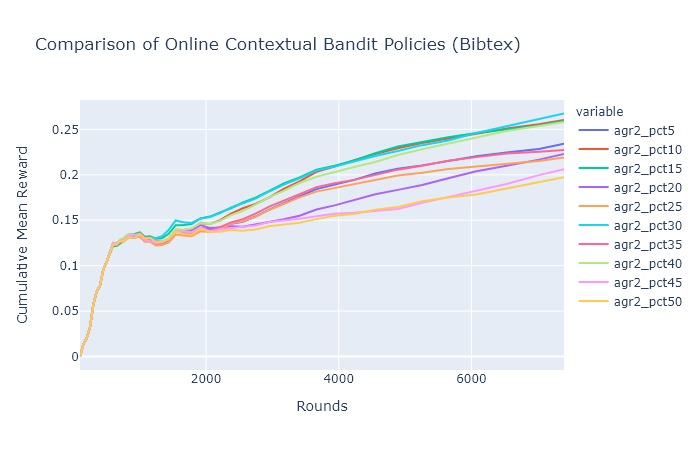

time: 328 ms (started: 2021-05-11 18:07:18 -04:00)


In [30]:
df_reward = pd.read_csv(os.path.join(res_path, 'tuning',
                                     f'{dataset}_{model_name}_rewards.csv'), index_col=0)
fig = px.line(df_reward.cumsum().divide(df_reward.index.values.reshape(-1,1)),
              title=f'''Comparison of Online Contextual Bandit Policies ({dataset})''')
fig.update_yaxes(title='Cumulative Mean Reward')
fig.update_xaxes(title='Rounds')
fig.show()


#### ActiveExplorer

In [31]:
model_name = 'ac'

# build hyperparameter grid (seperate models)
model_dict={}
for i in np.arange(0.05, 0.51, 0.05):
    label = str(int(np.round(100*i)))
    model_dict[f'{model_name}_thr{label}'] = ActiveExplorer(deepcopy(base_algorithm), 
                                                    nchoices = nchoices,
                                                    beta_prior=beta_prior, 
                                                    random_state=random_seed,
                                                    explore_prob=i)
    
reward_dict = {z:list() for z in model_dict.keys()}
ttime_dict = deepcopy(reward_dict)


time: 16 ms (started: 2021-05-11 18:07:18 -04:00)


In [32]:
# run simulation
model_dict, reward_dict, action_dict, ttime_dict, ns = \
run_simulation(X, y, model_dict, reward_dict, ttime_dict, 
               min_batch=min_batch_size, incr_batch_pct=incr_batch_pct)

# write out results
subfold = 'tuning'
df_action = pd.DataFrame(action_dict)
df_action.to_csv(os.path.join(res_path, subfold, 
                              f'{dataset}_{model_name}_actions.csv'))

df_reward = pd.DataFrame(reward_dict, index=ns)
df_reward.to_csv(os.path.join(res_path, subfold,
                              f'{dataset}_{model_name}_rewards.csv'))

df_ttime = pd.DataFrame(ttime_dict, index=ns)
df_ttime.to_csv(os.path.join(res_path, subfold,
                             f'{dataset}_{model_name}_train_time.csv'))


The models will be refit 46 times


  0%|          | 0/46 [00:00<?, ?it/s]

time: 2min 30s (started: 2021-05-11 18:07:18 -04:00)


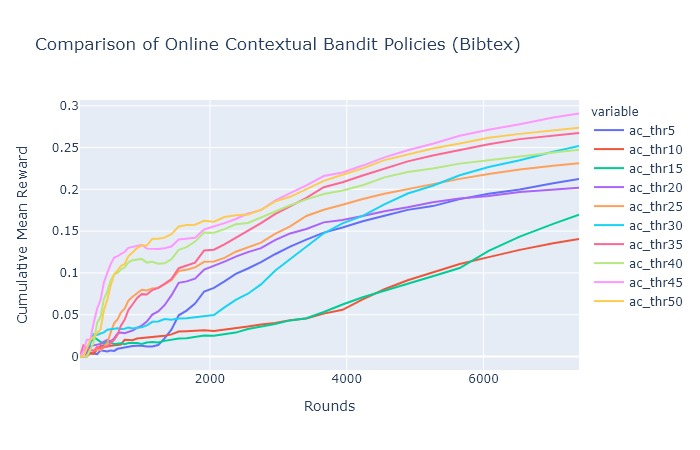

time: 312 ms (started: 2021-05-11 18:09:49 -04:00)


In [33]:
df_reward = pd.read_csv(os.path.join(res_path, 'tuning',
                                     f'{dataset}_{model_name}_rewards.csv'), index_col=0)
fig = px.line(df_reward.cumsum().divide(df_reward.index.values.reshape(-1,1)),
              title=f'''Comparison of Online Contextual Bandit Policies ({dataset})''')
fig.update_yaxes(title='Cumulative Mean Reward')
fig.update_xaxes(title='Rounds')
fig.show()


#### ActiveAdaptiveGreedy

In [34]:
model_name = 'aac'
adaptive_active_greedy = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                                        active_choice='weighted', 
                                        decay_type='percentile', decay=0.9997,
                                        beta_prior=beta_prior, random_state = random_seed)

# build hyperparameter grid (seperate models)
model_dict={}
for i in np.arange(5, 51, 5):
    label = str(int(np.round(i)))
    model_dict[f'{model_name}_pct{label}'] = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                                      active_choice='weighted',
                                      decay_type='percentile', decay=0.9997, 
                                      percentile=int(np.round(i)),
                                      beta_prior=beta_prior, random_state = random_seed)
    
reward_dict = {z:list() for z in model_dict.keys()}
ttime_dict = deepcopy(reward_dict)

time: 16 ms (started: 2021-05-11 18:09:49 -04:00)


In [35]:
# run simulation
model_dict, reward_dict, action_dict, ttime_dict, ns = \
run_simulation(X, y, model_dict, reward_dict, ttime_dict, 
               min_batch=min_batch_size, incr_batch_pct=incr_batch_pct)

# write out results
subfold = 'tuning'
df_action = pd.DataFrame(action_dict)
df_action.to_csv(os.path.join(res_path, subfold, 
                              f'{dataset}_{model_name}_actions.csv'))

df_reward = pd.DataFrame(reward_dict, index=ns)
df_reward.to_csv(os.path.join(res_path, subfold,
                              f'{dataset}_{model_name}_rewards.csv'))

df_ttime = pd.DataFrame(ttime_dict, index=ns)
df_ttime.to_csv(os.path.join(res_path, subfold,
                             f'{dataset}_{model_name}_train_time.csv'))

The models will be refit 46 times


  0%|          | 0/46 [00:00<?, ?it/s]

time: 2min 23s (started: 2021-05-11 18:09:49 -04:00)


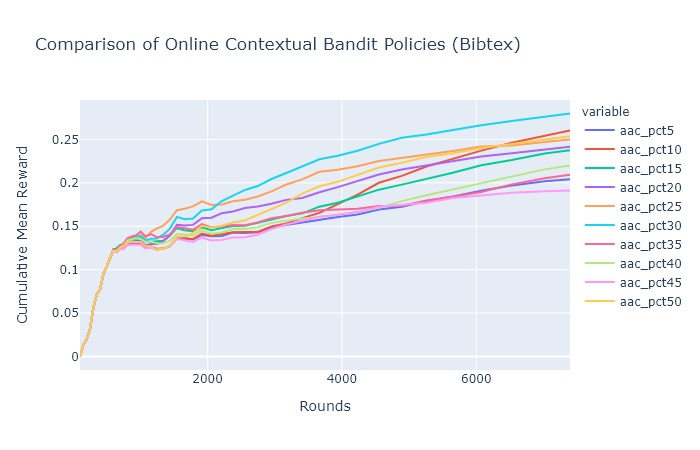

time: 313 ms (started: 2021-05-11 18:12:12 -04:00)


In [36]:
df_reward = pd.read_csv(os.path.join(res_path, 'tuning',
                                     f'{dataset}_{model_name}_rewards.csv'), index_col=0)
fig = px.line(df_reward.cumsum().divide(df_reward.index.values.reshape(-1,1)),
              title=f'''Comparison of Online Contextual Bandit Policies ({dataset})''')
fig.update_yaxes(title='Cumulative Mean Reward')
fig.update_xaxes(title='Rounds')
fig.show()


#### BootstrappedUCB

In [37]:
model_name = 'ucb_pct'

# build hyperparameter grid (seperate models)
model_dict={}
for i in np.arange(50, 91, 10):
    label = str(int(np.round(i)))
    model_dict[f'{model_name}_{label}'] = BootstrappedUCB(deepcopy(base_algorithm), 
                                                             nchoices=nchoices,
                                                             beta_prior=beta_prior_ucb, 
                                                             percentile = i,
                                                             random_state=random_seed)
    
reward_dict = {z:list() for z in model_dict.keys()}
ttime_dict = deepcopy(reward_dict)

time: 16 ms (started: 2021-05-11 18:12:13 -04:00)


In [38]:
# run simulation
model_dict, reward_dict, action_dict, ttime_dict, ns = \
run_simulation(X, y, model_dict, reward_dict, ttime_dict, 
               min_batch=min_batch_size, incr_batch_pct=incr_batch_pct)

# write out results
subfold = 'tuning'
df_action = pd.DataFrame(action_dict)
df_action.to_csv(os.path.join(res_path, subfold, 
                              f'{dataset}_{model_name}_actions.csv'))

df_reward = pd.DataFrame(reward_dict, index=ns)
df_reward.to_csv(os.path.join(res_path, subfold,
                              f'{dataset}_{model_name}_rewards.csv'))

df_ttime = pd.DataFrame(ttime_dict, index=ns)
df_ttime.to_csv(os.path.join(res_path, subfold,
                             f'{dataset}_{model_name}_train_time.csv'))


The models will be refit 46 times


  0%|          | 0/46 [00:00<?, ?it/s]

time: 6min 59s (started: 2021-05-11 18:12:13 -04:00)


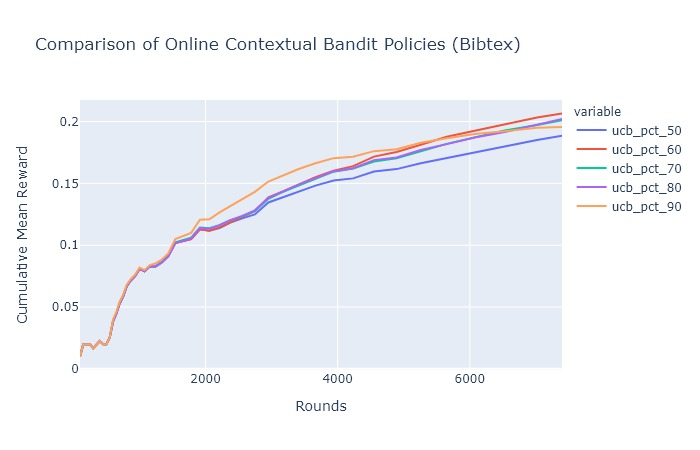

time: 234 ms (started: 2021-05-11 18:19:12 -04:00)


In [39]:
df_reward = pd.read_csv(os.path.join(res_path, 'tuning',
                                     f'{dataset}_{model_name}_rewards.csv'), index_col=0)
fig = px.line(df_reward.cumsum().divide(df_reward.index.values.reshape(-1,1)),
              title=f'''Comparison of Online Contextual Bandit Policies ({dataset})''')
fig.update_yaxes(title='Cumulative Mean Reward')
fig.update_xaxes(title='Rounds')
fig.show()

In [40]:
# this time adjust the nsamples parameter
model_name = 'ucb_ns'

# build hyperparameter grid (seperate models)
model_dict={}
for i in [10, 25, 50]:
    label = str(int(np.round(i)))
    model_dict[f'{model_name}_{label}'] = BootstrappedUCB(deepcopy(base_algorithm), 
                                                             nchoices=nchoices,
                                                             beta_prior=beta_prior_ucb, 
                                                             percentile = 0.80,
                                                             nsamples=i,
                                                             random_state=random_seed)
    
reward_dict = {z:list() for z in model_dict.keys()}
ttime_dict = deepcopy(reward_dict)

time: 15 ms (started: 2021-05-11 18:19:12 -04:00)


In [41]:
# run simulation
model_dict, reward_dict, action_dict, ttime_dict, ns = \
run_simulation(X, y, model_dict, reward_dict, ttime_dict, 
               min_batch=min_batch_size, incr_batch_pct=incr_batch_pct)

# write out results
subfold = 'tuning'
df_action = pd.DataFrame(action_dict)
df_action.to_csv(os.path.join(res_path, subfold, 
                              f'{dataset}_{model_name}_actions.csv'))

df_reward = pd.DataFrame(reward_dict, index=ns)
df_reward.to_csv(os.path.join(res_path, subfold,
                              f'{dataset}_{model_name}_rewards.csv'))

df_ttime = pd.DataFrame(ttime_dict, index=ns)
df_ttime.to_csv(os.path.join(res_path, subfold,
                             f'{dataset}_{model_name}_train_time.csv'))

The models will be refit 46 times


  0%|          | 0/46 [00:00<?, ?it/s]

time: 9min 52s (started: 2021-05-11 18:19:12 -04:00)


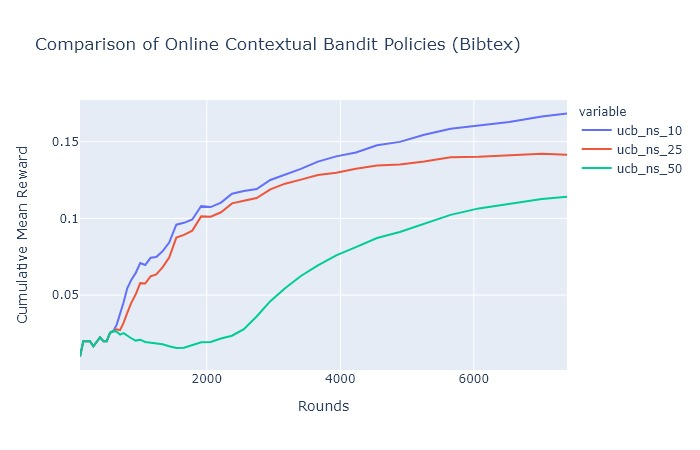

time: 219 ms (started: 2021-05-11 18:29:04 -04:00)


In [42]:
df_reward = pd.read_csv(os.path.join(res_path, 'tuning',
                                     f'{dataset}_{model_name}_rewards.csv'), index_col=0)
fig = px.line(df_reward.cumsum().divide(df_reward.index.values.reshape(-1,1)),
              title=f'''Comparison of Online Contextual Bandit Policies ({dataset})''')
fig.update_yaxes(title='Cumulative Mean Reward')
fig.update_xaxes(title='Rounds')
fig.show()

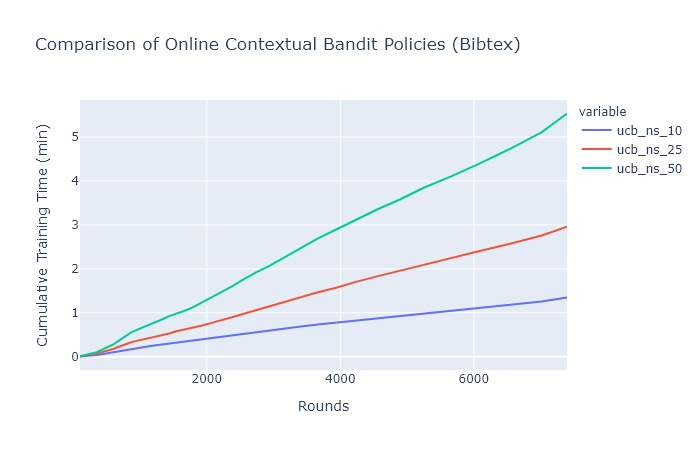

time: 172 ms (started: 2021-05-11 18:29:05 -04:00)


In [43]:
df_ttime = pd.read_csv(os.path.join(res_path, 'tuning',
                                    f'{dataset}_{model_name}_train_time.csv'), index_col=0)
fig = px.line(df_ttime.cumsum(),
              title=f'''Comparison of Online Contextual Bandit Policies ({dataset})''')
fig.update_yaxes(title='Cumulative Training Time (min)')
fig.update_xaxes(title='Rounds')
fig.show()


#### Bootstrapped Thomson Sampling

In [44]:
model_name = 'ts_ns'

# build hyperparameter grid (seperate models)
model_dict={}
for i in [10, 25, 50]:
    label = str(int(np.round(i)))
    model_dict[f'{model_name}_{label}'] = BootstrappedTS(deepcopy(base_algorithm), 
                                                         nchoices=nchoices,
                                                         beta_prior=beta_prior_ts,
                                                         nsamples=i,
                                                         random_state=random_seed)
    
reward_dict = {z:list() for z in model_dict.keys()}
ttime_dict = deepcopy(reward_dict)

time: 16 ms (started: 2021-05-11 18:29:05 -04:00)


In [45]:
# run simulation
model_dict, reward_dict, action_dict, ttime_dict, ns = \
run_simulation(X, y, model_dict, reward_dict, ttime_dict, 
               min_batch=min_batch_size, incr_batch_pct=incr_batch_pct)

# write out results
subfold = 'tuning'
df_action = pd.DataFrame(action_dict)
df_action.to_csv(os.path.join(res_path, subfold, 
                              f'{dataset}_{model_name}_actions.csv'))

df_reward = pd.DataFrame(reward_dict, index=ns)
df_reward.to_csv(os.path.join(res_path, subfold,
                              f'{dataset}_{model_name}_rewards.csv'))

df_ttime = pd.DataFrame(ttime_dict, index=ns)
df_ttime.to_csv(os.path.join(res_path, subfold,
                             f'{dataset}_{model_name}_train_time.csv'))


The models will be refit 46 times


  0%|          | 0/46 [00:00<?, ?it/s]

time: 6min 41s (started: 2021-05-11 18:29:05 -04:00)


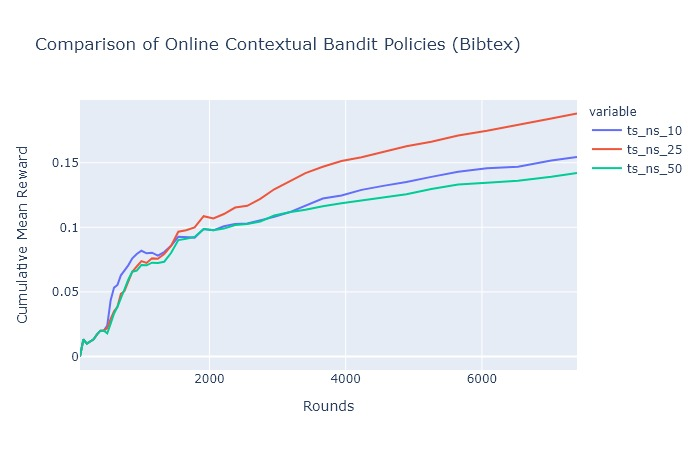

time: 218 ms (started: 2021-05-11 18:35:47 -04:00)


In [46]:
df_reward = pd.read_csv(os.path.join(res_path, 'tuning',
                                     f'{dataset}_{model_name}_rewards.csv'), index_col=0)
fig = px.line(df_reward.cumsum().divide(df_reward.index.values.reshape(-1,1)),
              title=f'''Comparison of Online Contextual Bandit Policies ({dataset})''')
fig.update_yaxes(title='Cumulative Mean Reward')
fig.update_xaxes(title='Rounds')
fig.show()


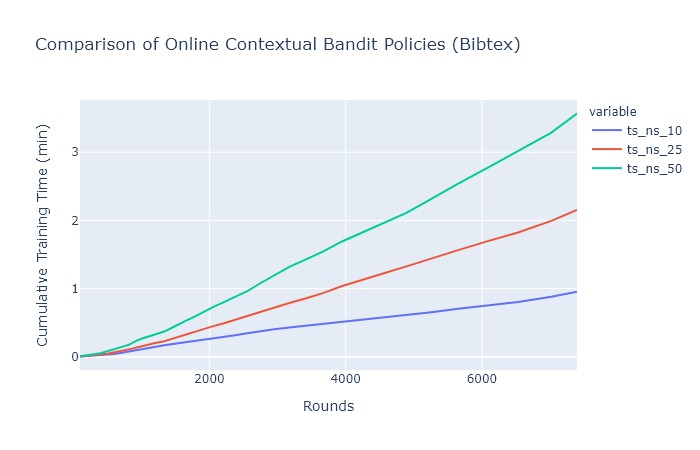

time: 172 ms (started: 2021-05-11 18:35:47 -04:00)


In [47]:
df_ttime = pd.read_csv(os.path.join(res_path, 'tuning',
                                    f'{dataset}_{model_name}_train_time.csv'), index_col=0)
fig = px.line(df_ttime.cumsum(),
              title=f'''Comparison of Online Contextual Bandit Policies ({dataset})''')
fig.update_yaxes(title='Cumulative Training Time (min)')
fig.update_xaxes(title='Rounds')
fig.show()

<a id="p33"></a>
** *
### 3.3 Streaming models

Same data and metaheuristics as before, but this time fitting the data in small batches, without letting the algorithms have access to all their historical data - this time the algorithms are scikit-learn's `SGDClassifier` and this module's `LinearRegression`, as these metaheuristics assume a `partial_fit` method.

Note1: unlike `SGDClassifier` this module's `LinearRegression` is not stochastic, but rather, keeps the matrices from the closed-form solution and updates them incrementally.

Note2: these methods used with streaming data are a lot more sensitive to hyperparameters such as `beta_prior` or `smoothing` and to differences in random seeds. Be sure to tune the hyperparameters well.

**Note3:** This package assumes that it is passed binary classifiers as base algorithm, but here sometimes it is passed a regressor, which is technically incorrect, but still gives reasonable results. As well, the `smoothing` transformation becomes incorrect when the predictions are unbounded, but performance-wise it doesn't matter too much.

**Important:** These streaming-data examples use a lot of RAM memory. This is due to `LinearRegression` and `LinUCB` keeping track of the matrices they calculate for each arm, which scales quadratically with the number of features. Due to memory constraints, not all methods are shown here. This section uses around 7.5GB of RAM (vs. around 1.8GB from the previous example).

In [11]:
from sklearn.linear_model import SGDClassifier
from contextualbandits.linreg import LinearRegression
from contextualbandits.online import LinUCB, AdaptiveGreedy, \
        SoftmaxExplorer, ActiveExplorer, EpsilonGreedy

nchoices = y.shape[1]
base_sgd = SGDClassifier(random_state=123, loss='log', warm_start=False)
base_ols = LinearRegression(lambda_=10., fit_intercept=True, method="sm")

## Metaheuristic using different base algorithms and configurations
linucb = LinUCB(nchoices = nchoices, beta_prior = None, alpha = 0.1,
                ucb_from_empty = False, random_state = 1111)
### Important!!! the default hyperparameters for LinUCB in the reference paper
### are very different from what's used in this example
adaptive_active_greedy = AdaptiveGreedy(deepcopy(base_ols), nchoices = nchoices,
                                        smoothing = None, beta_prior = ((3./nchoices,4.), 2),
                                        active_choice = 'weighted', decay_type = 'percentile',
                                        decay = 0.9997, batch_train = True,
                                        random_state = 2222)
softmax_explorer = SoftmaxExplorer(deepcopy(base_sgd), nchoices = nchoices,
                                   smoothing = (1,2), beta_prior = None, batch_train = True,
                                   refit_buffer = 50, deep_copy_buffer = False, random_state = 3333)
adaptive_greedy_perc = AdaptiveGreedy(deepcopy(base_ols), nchoices = nchoices,
                                      smoothing = (1,2), beta_prior = None,
                                      decay_type = 'percentile', decay = 0.9997, batch_train = True,
                                      random_state = 4444)
active_explorer = ActiveExplorer(deepcopy(base_sgd), smoothing = None, nchoices = nchoices,
                                 beta_prior = ((3./nchoices, 4.), 2), batch_train = True, refit_buffer = 50,
                                 deep_copy_buffer = False, random_state = 5555)
epsilon_greedy_nodecay = EpsilonGreedy(deepcopy(base_ols), nchoices = nchoices,
                                       smoothing = (1,2), beta_prior = None,
                                       decay = None, batch_train = True,
                                       deep_copy_buffer = False, random_state = 6666)


models = [linucb, adaptive_active_greedy, softmax_explorer, adaptive_greedy_perc,
          active_explorer, epsilon_greedy_nodecay]

time: 15 ms (started: 2021-05-03 15:25:02 -04:00)


Now running the experiment:

In [12]:
# These lists will keep track of the rewards obtained by each policy
rewards_lucb, rewards_aac, rewards_sft, rewards_agr, \
rewards_ac, rewards_egr = [list() for i in range(len(models))]

lst_rewards = [rewards_lucb, rewards_aac, rewards_sft,
               rewards_agr, rewards_ac, rewards_egr]

# batch size - algorithms will be refit after N rounds
batch_size=50

# initial seed - all policies start with the same small random selection of actions/rewards
first_batch = X[:batch_size, :]
np.random.seed(1)
action_chosen = np.random.randint(nchoices, size=batch_size)
rewards_received = y[np.arange(batch_size), action_chosen]

# fitting models for the first time
for model in models:
    model.fit(X=first_batch, a=action_chosen, r=rewards_received)
    
# these lists will keep track of which actions does each policy choose
lst_a_lucb, lst_a_aac, lst_a_sft, lst_a_agr, \
lst_a_ac, lst_a_egr = [action_chosen.copy() for i in range(len(models))]

lst_actions = [lst_a_lucb, lst_a_aac, lst_a_sft,
               lst_a_agr, lst_a_ac, lst_a_egr]

# rounds are simulated from the full dataset
def simulate_rounds_stoch(model, rewards, actions_hist, X_batch, y_batch, rnd_seed):
    np.random.seed(rnd_seed)
    
    ## choosing actions for this batch
    actions_this_batch = model.predict(X_batch).astype('uint8')
    
    # keeping track of the sum of rewards received
    rewards.append(y_batch[np.arange(y_batch.shape[0]), actions_this_batch].sum())
    
    # adding this batch to the history of selected actions
    new_actions_hist = np.append(actions_hist, actions_this_batch)
    
    # rewards obtained now
    rewards_batch = y_batch[np.arange(y_batch.shape[0]), actions_this_batch]
    
    # now refitting the algorithms after observing these new rewards
    np.random.seed(rnd_seed)
    model.partial_fit(X_batch, actions_this_batch, rewards_batch)
    
    return new_actions_hist

# now running all the simulation
for i in range(int(np.floor(X.shape[0] / batch_size))):
    batch_st = (i + 1) * batch_size
    batch_end = (i + 2) * batch_size
    batch_end = np.min([batch_end, X.shape[0]])
    
    X_batch = X[batch_st:batch_end, :]
    y_batch = y[batch_st:batch_end, :]
    
    for model in tqdm(range(len(models))):
        lst_actions[model] = simulate_rounds_stoch(models[model],
                                                   lst_rewards[model],
                                                   lst_actions[model],
                                                   X_batch, y_batch,
                                                   rnd_seed = batch_st)

time: 4min 45s (started: 2021-05-03 15:25:09 -04:00)


Visualizing results:

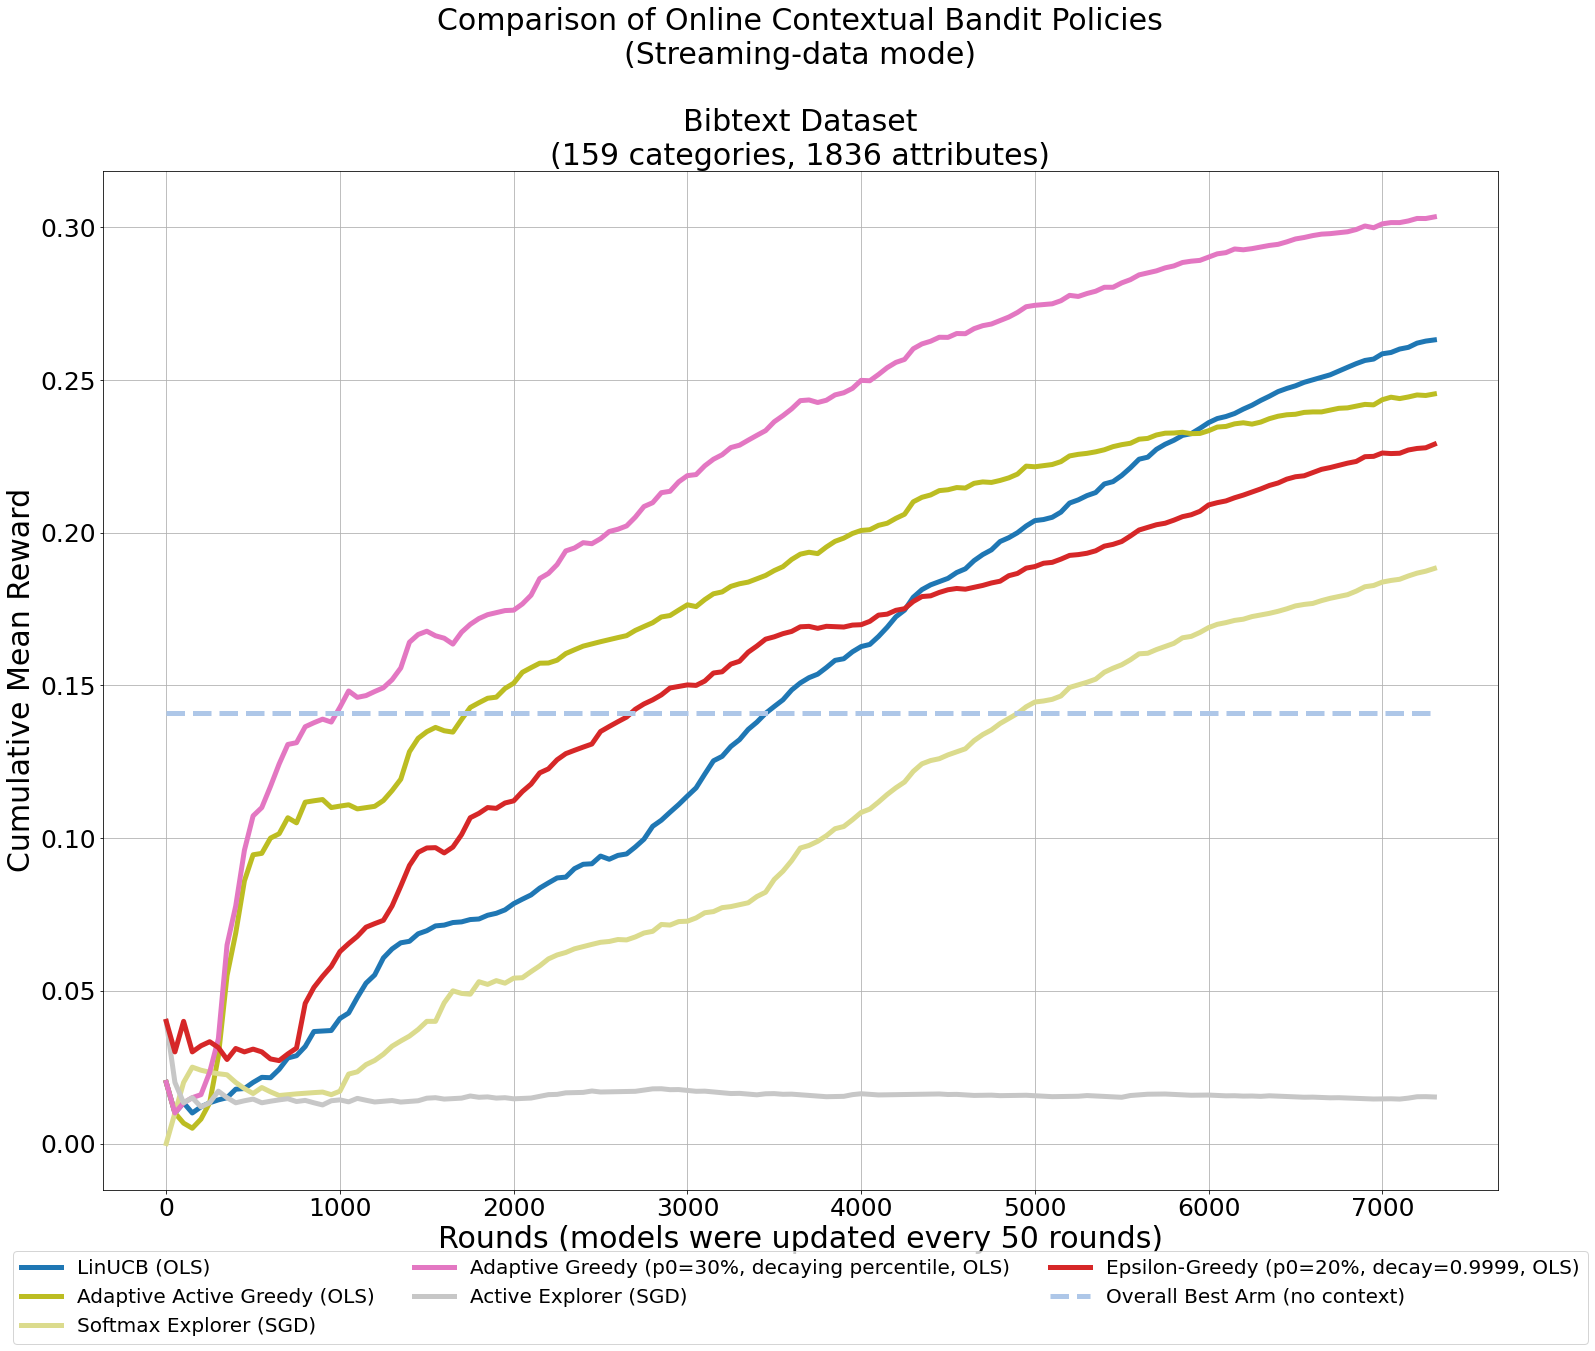

time: 407 ms (started: 2021-05-03 15:32:27 -04:00)


In [13]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))
rcParams['figure.figsize'] = 25, 15

ax = plt.subplot(111)
plt.plot(get_mean_reward(rewards_lucb), label="LinUCB (OLS)", linewidth=lwd,color=colors[0])
plt.plot(get_mean_reward(rewards_aac), label="Adaptive Active Greedy (OLS)", linewidth=lwd,color=colors[16])
plt.plot(get_mean_reward(rewards_sft), label="Softmax Explorer (SGD)", linewidth=lwd,color=colors[17])
plt.plot(get_mean_reward(rewards_agr), label="Adaptive Greedy (p0=30%, decaying percentile, OLS)", linewidth=lwd,color=colors[12])
plt.plot(get_mean_reward(rewards_ac), label="Active Explorer (SGD)", linewidth=lwd,color=colors[15])
plt.plot(get_mean_reward(rewards_egr), label="Epsilon-Greedy (p0=20%, decay=0.9999, OLS)",linewidth=lwd,color=colors[6])
plt.plot(np.repeat(y.mean(axis=0).max(),len(rewards_sft)), label="Overall Best Arm (no context)",linewidth=lwd,color=colors[1],ls='dashed')

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cumulative Mean Reward', size=30)
plt.title('Comparison of Online Contextual Bandit Policies\n(Streaming-data mode)\n\nBibtext Dataset\n(159 categories, 1836 attributes)',size=30)
plt.grid()
plt.show()

<a id="p4"></a>
## 4. References
* Cortes, David. "Adapting multi-armed bandits policies to contextual bandits scenarios." arXiv preprint arXiv:1811.04383 (2018).

* Katakis, I., Tsoumakas, G., & Vlahavas, I. (2008, September). Multilabel text classification for automated tag suggestion. In Proceedings of the ECML/PKDD (Vol. 18).

* Snoek, C. G., Worring, M., Van Gemert, J. C., Geusebroek, J. M., & Smeulders, A. W. (2006, October). The challenge problem for automated detection of 101 semantic concepts in multimedia. In Proceedings of the 14th ACM international conference on Multimedia (pp. 421-430). ACM.

* Chapelle, O., & Li, L. (2011). An empirical evaluation of thompson sampling. In Advances in neural information processing systems (pp. 2249-2257).

* Agrawal, S., & Goyal, N. (2013, February). Thompson sampling for contextual bandits with linear payoffs. In International Conference on Machine Learning (pp. 127-135).

* Li, L., Chu, W., Langford, J., & Schapire, R. E. (2010, April). A contextual-bandit approach to personalized news article recommendation. In Proceedings of the 19th international conference on World wide web (pp. 661-670). ACM.

* Chakrabarti, D., Kumar, R., Radlinski, F., & Upfal, E. (2009). Mortal multi-armed bandits. In Advances in neural information processing systems (pp. 273-280).

* Vermorel, J., & Mohri, M. (2005, October). Multi-armed bandit algorithms and empirical evaluation. In European conference on machine learning (pp. 437-448). Springer, Berlin, Heidelberg.